# Research Question: To what extent did China's One-Child Policy (1979) cause a drop in fertility?

### PART 2: A comparative demographic study using Synthetic Control Method

#### Authored By: Srisha Raj
#### Data Sources: World Bank Group

## Step 1: Load Data

In [ ]:
pip install SyntheticControlMethods

  Preparing metadata (setup.py) ... done
  Created wheel for SyntheticControlMethods: filename=SyntheticControlMethods-1.1.17-py2.py3-none-any.whl size=27887 sha256=cf9476041c956de6bc701d79d9e536b349e6b1f13d5fca466513574c289582cf
  Stored in directory: /root/.cache/pip/wheels/6f/59/26/13c508416e04b638f32f0bc523cbe952d7868911309395e6c8
Successfully built SyntheticControlMethods


In [ ]:
from SyntheticControlMethods import Synth
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as plticker


## Step 2a: Primary dataset

In [ ]:
df_raw = pd.read_csv('API_SP.DYN.TFRT.IN_DS2_en_csv_v2_123473.csv', skiprows=4)

In [ ]:
df_raw.head(4)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,4.567000,4.422000,4.262000,4.107000,3.940000,3.797000,...,1.848000,1.785000,1.732000,1.701000,1.662000,1.631000,1.615000,1.602000,NaN,NaN
1,Africa Eastern and Southern,AFE,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,6.650330,6.667308,6.688246,6.709226,6.724930,6.737459,...,4.615744,4.569884,4.521443,4.471338,4.412973,4.350683,4.287033,4.223771,NaN,NaN
2,Afghanistan,AFG,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,7.282000,7.284000,7.292000,7.302000,7.304000,7.305000,...,5.542000,5.433000,5.327000,5.238000,5.145000,5.039000,4.932000,4.840000,NaN,NaN
3,Africa Western and Central,AFW,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,6.468887,6.478351,6.492277,6.500229,6.516739,6.532766,...,5.228976,5.098885,4.962571,4.829134,4.707399,4.637741,4.563354,4.497707,NaN,NaN


In [ ]:
df_long = df_raw.melt(id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
        var_name="Year",
        value_name="Total Fertility Rate").dropna(subset=["Total Fertility Rate"])

df_long["Year"] = df_long["Year"].astype(int)
df_long.head(4)
countries = [
    "China",
    "Thailand",
    "Turkiye",
    "Pakistan",
    "Philippines",
    "Sri Lanka",
    "Morocco",
    "Tunisia",
    "Korea, Rep.",
    "Brazil",
    "Mexico"
]

#Used to create a synthetic control; Selected for similarity in fertility trends, demographic landscape, and government structure to China
control_units = [
    "Thailand",
    "Turkiye",
    "Pakistan",
    "Philippines",
    "Sri Lanka",
    "Morocco",
    "Tunisia",
    "Korea, Rep.",
    "Brazil",
    "Mexico"
]

treatment_unit = ["China"]

df_use = df_long[df_long["Country Name"].isin(countries)]
df_use = df_use[df_long["Year"]<= 2015].drop(columns=["Country Code", "Indicator Name", "Indicator Code"])
df_use.head(4)

/tmp/ipython-input-3652137330.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_use = df_use[df_long["Year"]<= 2015].drop(columns=["Country Code", "Indicator Name", "Indicator Code"])


,Country Name,Year,Total Fertility Rate
29,Brazil,1960,6.051
40,China,1960,4.451
126,"Korea, Rep.",1960,5.994
138,Sri Lanka,1960,5.352


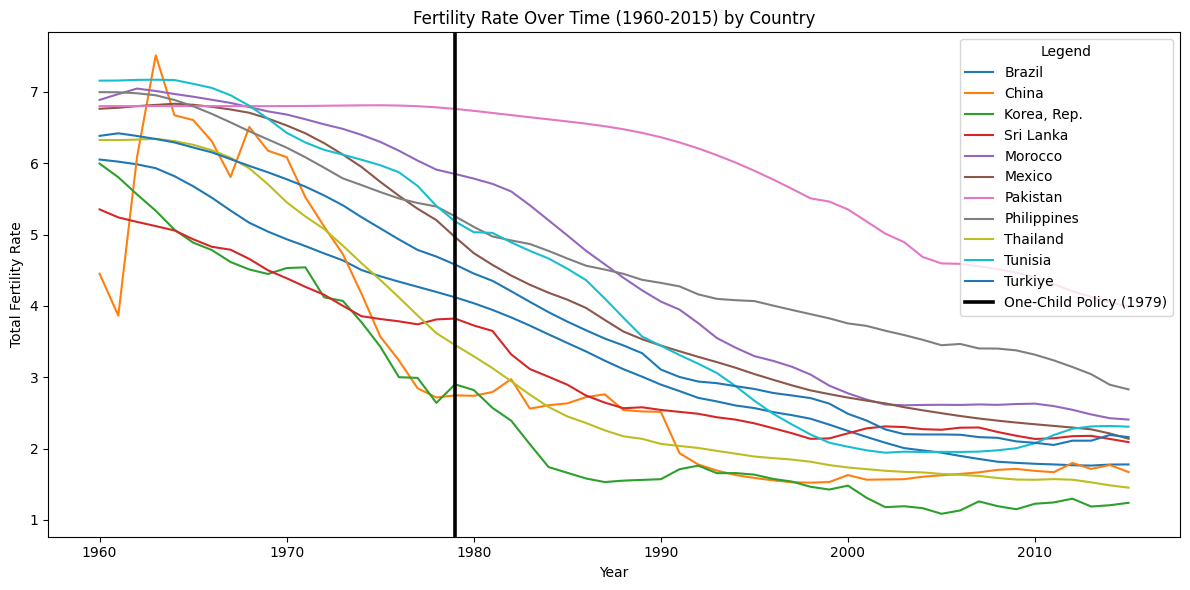

In [ ]:
#@title Fertility Rate Over Time (1960-2015) by Country

plt.figure(figsize=(12, 6))


# Loop through each country and plot
for country in df_use["Country Name"].unique():
    country_data = df_use[df_use["Country Name"] == country]
    plt.plot(country_data["Year"], country_data["Total Fertility Rate"], label=country)

# Labeling
plt.xlabel("Year")
plt.ylabel("Total Fertility Rate")
plt.title("Fertility Rate Over Time (1960-2015) by Country")


plt.axvline(x=1979, color='black', linestyle='-', lw=2.6,label='One-Child Policy (1979)')
plt.legend(title="Legend", loc='upper right')

plt.tight_layout()
plt.show()


## Step 2b: Covariate datasets

In [ ]:
df_urb = pd.read_csv('API_SP.URB.TOTL.IN.ZS_DS2_en_csv_v2_22447.csv', skiprows=4)
df_mor = pd.read_csv('API_SP.DYN.IMRT.IN_DS2_mortality.csv', skiprows=4)
df_gdp = pd.read_csv('API_NY.GDP.PCAP.CD_DS2_en_csv_v2_122367.csv', skiprows=4)
df_con = pd.read_csv('API_SP.DYN.CONU.ZS_DS2_en_csv_v2_35276.csv', skiprows=4)

'''
df_urb: Urban population (% of total population)
df_mor: Infant mortality rate (per 1,000 live births)
df_gdp: GDP per capita, current US$
df_con: Contraceptive prevalence, any method (% of married women ages 15-49)
'''

'\ndf_urb: Urban population (% of total population)\ndf_mor: Infant mortality rate (per 1,000 live births)\ndf_gdp: GDP per capita, current US$\ndf_con: Contraceptive prevalence, any method (% of married women ages 15-49)\n'

#### When you have a lot of covariate code like this, it's helpful to create a data dictionary:

In [ ]:
# Define your raw data sources in a dictionary

raw_datasets = {
    "GDP per capita (current US$)": df_gdp,
    "Mortality rate, infant (per 1,000 live births)": df_mor,
    "Urban population (% of total population)": df_urb,
    "Contraceptive prevalence, any method (% of married women ages 15-49)": df_con
}


#predefined set of countries in donor pool using var 'countries'

#processing:
covariate_lst = []

#taking data till 2015
for target_var, df in raw_datasets.items():
    year_columns = [str(year) for year in range(1960, 2016) if str(year) in df.columns]
    df_clean = df[["Country Name", "Country Code", "Indicator Name", "Indicator Code"] + year_columns]

    df_long = df_clean.melt(
        id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
        var_name="Year",
        value_name=target_var
    )

    df_long["Year"] = pd.to_numeric(df_long["Year"], errors="coerce")
    df_long = df_long.dropna()
    df_long = df_long[df_long["Country Name"].isin(countries)]

    df_long["Year"] = df_long["Year"].astype(int)

    # Drop extra columns
    df_long = df_long.drop(columns=["Country Code", "Indicator Name", "Indicator Code"])

    #List of Covariate DataFrames
    covariate_lst.append(df_long)



In [ ]:
df_all = df_use.copy()
for df in covariate_lst:
    df_all = pd.merge(df_all, df, on=["Country Name", "Year"], how="left")

In [ ]:
df_all = df_all.sort_values(by=["Country Name", "Year"])
df_all
df_experiment = df_all.iloc[:,:3]
#df_experiment.groupby(["Country Name","Year"]).filter(lambda x: len(x)>1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

def minmax_scale_covariates_preserve_nans(df, columns_to_scale):
    df_scaled = df.copy()
    scaler = MinMaxScaler()

    for col in columns_to_scale:
        col_data = df[[col]].values  # 2D array (n, 1)
        mask = ~np.isnan(col_data).flatten()  # Boolean mask for non-NaNs

        # Initialize output array with NaNs
        scaled_values = np.full_like(col_data, np.nan, dtype=np.float64)

        # Scale only non-NaN values
        scaled_values[mask, 0] = scaler.fit_transform(col_data[mask].reshape(-1, 1)).flatten()

        df_scaled[col] = scaled_values.flatten()

    return df_scaled


df_scaled = minmax_scale_covariates_preserve_nans(df_all, ["GDP per capita (current US$)",
                                        "Mortality rate, infant (per 1,000 live births)",
                                        "Urban population (% of total population)",
                                        "Contraceptive prevalence, any method (% of married women ages 15-49)"
                                        ])

df_scaled.head(3)

,Country Name,Year,Total Fertility Rate,GDP per capita (current US$),"Mortality rate, infant (per 1,000 live births)",Urban population (% of total population),"Contraceptive prevalence, any method (% of married women ages 15-49)"
0,Brazil,1960,6.051,0.005627,0.700908,0.430319,NaN
11,Brazil,1961,6.022,0.005500,0.683314,0.444449,NaN
22,Brazil,1962,5.984,0.006139,0.666856,0.458493,NaN


In [ ]:
covariate_df = df_scaled.iloc[:,3:]
covariate_df.head(2)

,GDP per capita (current US$),"Mortality rate, infant (per 1,000 live births)",Urban population (% of total population),"Contraceptive prevalence, any method (% of married women ages 15-49)"
0,0.005627,0.700908,0.430319,NaN
11,0.005500,0.683314,0.444449,NaN


## Implementing Synthetic Control Method

### SCM Method 1: pysyncon

[Pysynson](https://github.com/sdfordham/pysyncon) is a python module for the synthetic control method.

Referenced by:
- Synthetic Control Method (Abadie & Gardeazabal 2003)
- Robust Synthetic Control Method (Amjad, Shah & Shen 2018)
- Augmented Synthetic Control Method (Ben-Michael, Feller & Rothstein 2021)
- Penalized Synthetic Control Method (Abadie & L'Hour 2021)

In [ ]:
pip install pysyncon

In [ ]:
from pysyncon import Dataprep, Synth

In [ ]:
dataprep = Dataprep(foo = df_scaled,
                    predictors= ["GDP per capita (current US$)",
                                 "Mortality rate, infant (per 1,000 live births)",
                                 "Urban population (% of total population)",
                                 "Contraceptive prevalence, any method (% of married women ages 15-49)"],
                    predictors_op = "mean",
                    unit_variable = "Country Name",
                    time_variable="Year",
                    treatment_identifier = "China",
                    controls_identifier = [ "Thailand", "Turkiye","Pakistan", "Philippines","Sri Lanka","Morocco","Tunisia","Korea, Rep.","Brazil","Mexico"],
                    time_predictors_prior = range(1960,1970),
                    dependent = "Total Fertility Rate",
                    time_optimize_ssr = range(1970, 1979)
                                        )

print(dataprep)

Dataprep
Treated unit: China
Dependent variable: Total Fertility Rate
Control units: Thailand, Turkiye, Pakistan, Philippines, Sri Lanka, Morocco, Tunisia, Korea, Rep., Brazil, Mexico
Time range in data: 1960 - 2015
Time range for loss minimization: range(1970, 1979)
Time range for predictors: range(1960, 1970)
Predictors: GDP per capita (current US$), Mortality rate, infant (per 1,000 live births), Urban population (% of total population), Contraceptive prevalence, any method (% of married women ages 15-49)



In [ ]:
synth = Synth()
#optim_method="BFGS", optim_initial="ols"
synth.fit(dataprep=dataprep, custom_V=synth_train.V)

In [ ]:
synth.weights().sort_values(ascending=False)

,weights
Thailand,0.1
Turkiye,0.1
Pakistan,0.1
Philippines,0.1
Sri Lanka,0.1
Morocco,0.1
Tunisia,0.1
"Korea, Rep.",0.1
Brazil,0.1
Mexico,0.1


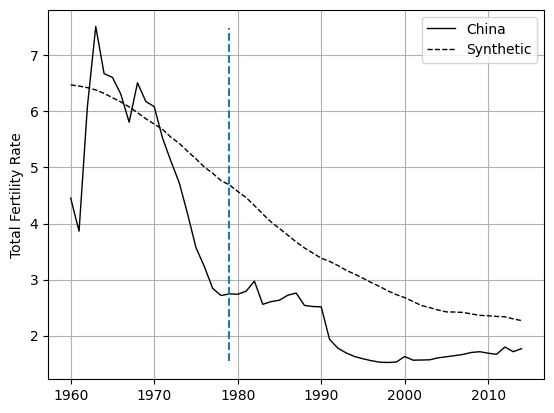

In [ ]:
synth.path_plot(time_period = range(1960,2015), treatment_time = 1979)

In [ ]:
synth.summary()

,V,treated,synthetic,sample mean
GDP per capita (current US$),0.25,0.003,0.018,0.018
"Mortality rate, infant (per 1,000 live births)",0.25,0.374,0.456,0.456
Urban population (% of total population),0.25,0.017,0.335,0.335
"Contraceptive prevalence, any method (% of married women ages 15-49)",0.25,NaN,0.279,0.349


## SCM Method 2: CausalPy

[CausalPy](https://causalpy.readthedocs.io/en/latest/notebooks/sc_pymc.html) is a Python package focusing on causal inference for quasi-experiments.

In [ ]:
pip install causalpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.7/244.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.0 MB/s eta 0:00:00


In [ ]:
import causalpy as cp

In [ ]:
test_df = cp.load_data("sc")
test_df.head(3)


,a,b,c,d,e,f,g,counterfactual,causal effect,actual
0,0.793234,1.277264,-0.055407,-0.791535,1.075170,0.817384,-2.607528,0.144888,-0.0,0.398287
1,1.841898,1.185068,-0.221424,-1.430772,1.078303,0.890110,-3.108099,0.601862,-0.0,0.491644
2,2.867102,1.922957,-0.153303,-1.429027,1.432057,1.455499,-3.149104,1.060285,-0.0,1.232330


In [ ]:
df_causal = df_use.pivot_table(index="Year", columns="Country Name", values="Total Fertility Rate")
df_causal = df_causal[df_causal.index>1961]
df_causal.head(3)

Country Name,Brazil,China,"Korea, Rep.",Mexico,Morocco,Pakistan,Philippines,Sri Lanka,Thailand,Tunisia,Turkiye
Year,,,,,,,,,,,
1962,5.984,6.085,5.562,6.800,7.046,6.8,6.980,5.177,6.331,7.168,6.382
1963,5.930,7.513,5.334,6.817,7.012,6.8,6.952,5.118,6.342,7.170,6.339
1964,5.818,6.672,5.068,6.833,6.970,6.8,6.886,5.057,6.309,7.166,6.291


In [ ]:
control_units_exp = ["Indonesia","Bangladesh","Pakistan","Philippines","Egypt, Arab Rep.","Morocco","Ghana","Kenya","Brazil","Mexico"]
treatment_unit_exp = ["China"]

###Causal Py: Linear Regression

In [ ]:
from causalpy.pymc_models import LinearRegression

In [ ]:
result_1 = cp.SyntheticControl(
    df_causal,
    treatment_time= 1979,
    control_units=control_units,
    treated_units=treatment_unit,
    model = cp.pymc_models.LinearRegression(
        sample_kwargs={"target_accept": 0.95}
))

Output()

ERROR:pymc.stats.convergence:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


(-500.0, 500.0)

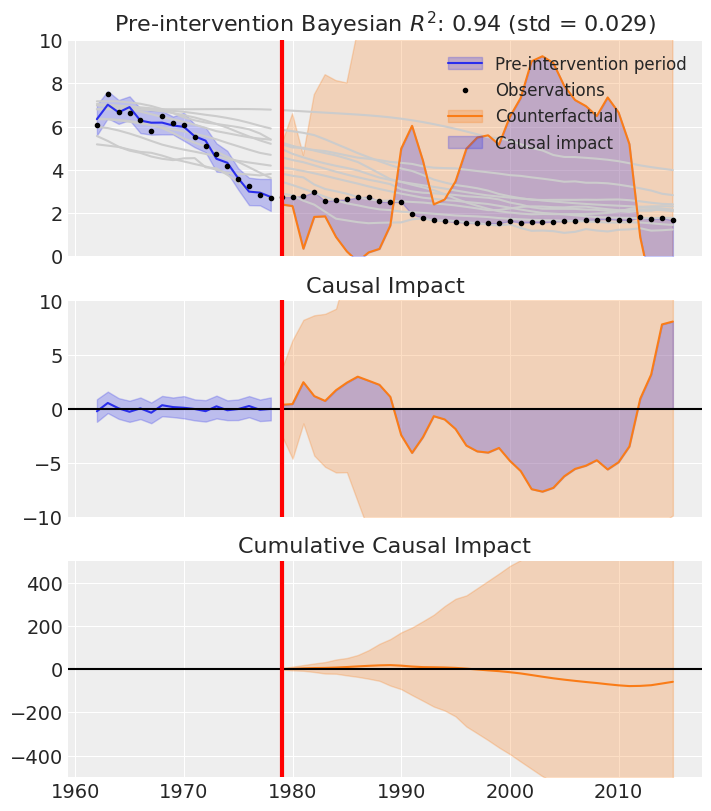

In [ ]:
fig, ax = result_1.plot(plot_predictors = True)

ax[0].set_ylim(0, 10)  # Adjust this as needed for the top panel
ax[1].set_ylim(-10, 10)  # Middle panel
ax[2].set_ylim(-500, 500)  # Cumulative impact panel

In [ ]:
result_1.summary(round_to=3)

================================SyntheticControl================================
Control units: ['Thailand', 'Turkiye', 'Pakistan', 'Philippines', 'Sri Lanka', 'Morocco', 'Tunisia', 'Korea, Rep.', 'Brazil', 'Mexico']
Treated unit: China
Model coefficients:
    Thailand     8.68, 94% HDI [-12.2, 34]
    Turkiye      -28.3, 94% HDI [-69.1, 5.9]
    Pakistan     -2.29, 94% HDI [-18.4, 14]
    Philippines  7.83, 94% HDI [-5.81, 22.7]
    Sri Lanka    -3.28, 94% HDI [-10.9, 7.46]
    Morocco      13.2, 94% HDI [-11, 39.4]
    Tunisia      -11, 94% HDI [-28.5, 2.97]
    Korea, Rep.  -0.745, 94% HDI [-3.02, 1.71]
    Brazil       8.21, 94% HDI [-1.55, 21]
    Mexico       7.45, 94% HDI [-5.74, 26.9]
    sigma        0.398, 94% HDI [0.243, 0.706]


###Causal Py: Weighted Sum Fitter

In [ ]:
result_2 = cp.SyntheticControl(
    df_causal,
    treatment_time= 1979,
    control_units=control_units,
    treated_units=treatment_unit,
    model = cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95}
))

Output()

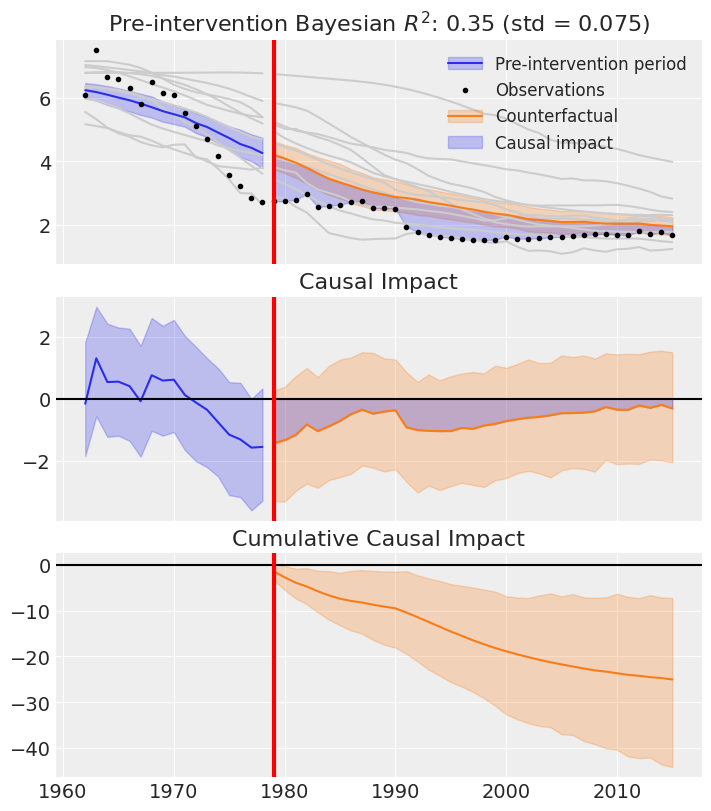

In [ ]:
fig, ax = result_2.plot(plot_predictors = True)

In [ ]:
result_2.summary(round_to=3)

================================SyntheticControl================================
Control units: ['Thailand', 'Turkiye', 'Pakistan', 'Philippines', 'Sri Lanka', 'Morocco', 'Tunisia', 'Korea, Rep.', 'Brazil', 'Mexico']
Treated unit: China
Model coefficients:
    Thailand     0.198, 94% HDI [0.00747, 0.532]
    Turkiye      0.0865, 94% HDI [0.00188, 0.295]
    Pakistan     0.0437, 94% HDI [0.00135, 0.148]
    Philippines  0.0757, 94% HDI [0.00221, 0.253]
    Sri Lanka    0.0993, 94% HDI [0.00311, 0.305]
    Morocco      0.0598, 94% HDI [0.00235, 0.191]
    Tunisia      0.0733, 94% HDI [0.00275, 0.231]
    Korea, Rep.  0.188, 94% HDI [0.014, 0.437]
    Brazil       0.1, 94% HDI [0.00402, 0.324]
    Mexico       0.076, 94% HDI [0.00252, 0.245]
    sigma        0.922, 94% HDI [0.645, 1.31]


###Causal Py: Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge

result_3 = cp.SyntheticControl(
    df_causal,
    treatment_variable="Country Name",
    outcome_variable="Total Fertility Rate",
    time_variable="Year",
    treated_units=treatment_unit,
    control_units=control_units,
    treatment_time=1979,
    model=Ridge(alpha=1.0)  # Adjust alpha as a hyperparameter
)


ValueError: 'y1' is not 1-dimensional

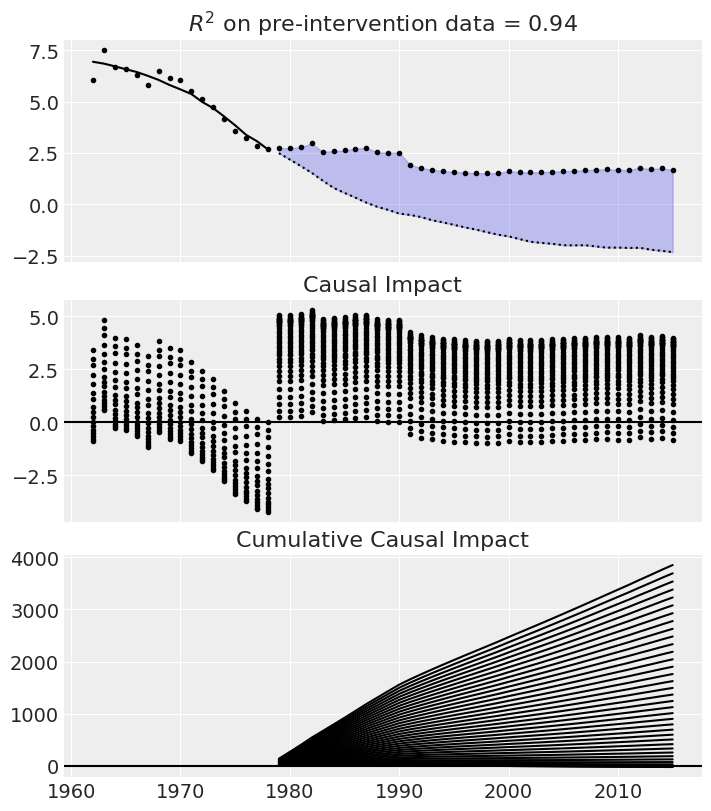

In [ ]:
fig, ax = result_3.plot(plot_predictors = True)


In [ ]:
result_3.summary(round_to=3)

================================SyntheticControl================================
Control units: ['Thailand', 'Turkiye', 'Pakistan', 'Philippines', 'Sri Lanka', 'Morocco', 'Tunisia', 'Korea, Rep.', 'Brazil', 'Mexico']
Treated unit: China
Model coefficients:
  Thailand   	     0.519
  Turkiye    	      0.28
  Pakistan   	  -0.00453
  Philippines	     0.136
  Sri Lanka  	    0.0679
  Morocco    	     0.156
  Tunisia    	    0.0596
  Korea, Rep.	     0.358
  Brazil     	   -0.0481
  Mexico     	     0.521


## Analysis

For this project on the effects of the One-Child Policy, I tested two versions of the Synthetic Control Method using **pysyncon** and **causalpy**.

**pysyncon** restricts donor pool weights to be non-negative and sum to one. Under this setup, the regression assigned nearly uniform weights (~0.1) to all countries in the donor pool, producing a synthetic control that lacked descriptive value.

**causalpy**, which allows for negative coefficients, generated a slightly more informative fit. In this case, Thailand emerged as the most influential contributor in the donor pool, with a weight of 0.519.

However, neither approach produced a convincing counterfactual for China’s fertility trajectory. The main limitation lies in the assumption that pre-intervention fertility trends would have continued in the same way after the policy’s introduction—an assumption not well supported given the scale and uniqueness of the One-Child Policy.

##Next Steps

Since the Synthetic Control Method did not yield reliable results, the next steps will shift focus toward:

- Narrowing the unit of analysis — instead of China as a whole, focus on a specific province or county where implementation was particularly strict or early.

- Comparative analysis with neighbors counties— compare that focal region to nearby regions that did not immediately implement fertility restrictions, creating a more realistic counterfactual.

- Expanding outcomes beyond fertility rates — test more descriptive indicators, such as shifts in gender balance, family structure, or even how public sentiment and emotions were expressed (e.g., through survey data, newspapers, or cultural records).

This approach will provide a more grounded comparison and a richer understanding of how the One-Child Policy reshaped both demographic patterns and lived experiences.